# Sampling

I had this problem once and decided to keep my simple approach.

__Here we want to consider the following problem:__

Say we have a large amount of data with many axis, for example, if we have data about people with the axes (sex, age, height), then maybe in order to choose a "correct" sample of the population, we can't take a uniform sample. This problem can occur when we have cases where possibly the data isn't representative of the overall population or when we just want to ensure that our sample will include enough examples of a specific trait.

   In creating this, we want to design a class that can be used to sample multiple dimensions simply. There are more complicated approaches for sampling multivariate distributions like [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling), which is used in order to obtain a sequence of observations which are from some multivariate probability distribution. As a Markov Chain Monte Carlo algorithm, Gibbs sampling generates a Markov chain of samples. A really good article on Markov Chain Monte Carlo is [Markov Chain Monte Carlo in Python](https://towardsdatascience.com/markov-chain-monte-carlo-in-python-44f7e609be98)

__We are going to begin with this function:__

In [2]:
import numpy as np
import bisect

def choosing_with_respect_to_prob_dist(axis_weights,sample_size=100):
    """
    Parameters
    ----------
    axis_weights: np.array() 1-D Array
    
    Returns
    -------
    np.array() with indices chosen according to the probability distribution defined by the axis weights
    
    Functional Code
    ---------------
        weights = abs(np.random.randn(10))
        weights/=np.sum(weights)
        bins = np.cumsum(weights)
        selections = np.random.uniform(size=10)
        
    Test Code
    ---------
        a = choosing_with_respect_to_prob_dist([1,2,3],sample_size=10000)
        print("Should be around .16: {}".format(np.sum(a==0)/10000))
        print("Should be around .33: {}".format(np.sum(a==1)/10000))
        print("Should be around .50: {}".format(np.sum(a==2)/10000))
    """
    weights = axis_weights/np.sum(axis_weights)
    bins = np.cumsum(weights)
    
    selections = np.random.uniform(size=sample_size)
    indices = [bisect.bisect_left(bins,s) for s in selections]
    
    return np.array(indices)

In [3]:
choosing_with_respect_to_prob_dist([1,2,3])

array([0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 1, 2, 2, 1, 1, 1, 1, 0,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 1, 1, 1, 0, 0,
       2, 0, 2, 1, 0, 2, 1, 2, 0, 0, 1, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 0, 2, 0, 2, 0, 2, 2, 1, 2, 2,
       1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1])

What it does is that given some axis weights with length n, it will sample $0,1,\dots,n-1$ according to the axis weights given. To check this we can look at the following test code example.

In [4]:
a = choosing_with_respect_to_prob_dist([1,2,3],sample_size=10000)

Setting this up, we see that we should select 0 around $\frac{1}{6}$th of the time, 1 around $\frac{2}{6}=\frac{1}{3}$th of the time, and 2 around $\frac{3}{6}=\frac{1}{2}$th of the time.

In [5]:
print("Should be around .16: {}".format(np.sum(a==0)/10000))
print("Should be around .33: {}".format(np.sum(a==1)/10000))
print("Should be around .50: {}".format(np.sum(a==2)/10000))

Should be around .16: 0.1665
Should be around .33: 0.331
Should be around .50: 0.5025


With the law of large numbers, we expect as we increase sample size, we should approach the true vcalues, but we are pretty darn close!

# Multi-axis Sampling

Say we need to sample from many axis. We can simply sample by choosing with respect to the appropriate probability distribution over each axis individually, our samples to obtain individual elements. For example, say we have an array with the shape of (3,3,3) which means that it has 3 axis with three elements each. If we sample over the first, second, and third axis and obtain \[0,1,2\], \[2,2,0\], \[1,1,2\] respectively, then we sample the points: (0,2,1),(1,2,1),(2,0,2). (In a way, we are combining all of the samples to get exact elements and we can do this by assuming independence on each of the axis which fails in some cases)

# A Class Oriented Approach

We can write this into a class to obtain:

In [15]:
class Sampler2D():
    def __init__(self,axis_weights):
        """
        Parameters
        ----------
        axis_weights: 2-D np.array() (axis_axis, probability_distribution_axis)
        """
        self.axis_weights = axis_weights
        
    def sample(self,sample_size):
        indices = []
        for prob_dist in self.axis_weights:
            indices.append(choosing_with_respect_to_prob_dist(prob_dist,sample_size=sample_size))
        
        return np.array(indices)

In [16]:
axis_1_weights = [1,2,3,4]
axis_2_weights = [1,1,1,1]
axis_3_weights = [0,1,0,1]

In [17]:
total_axis_weights = np.array([axis_1_weights,axis_2_weights,axis_3_weights])

In [18]:
sampler = Sampler2D(total_axis_weights)

In [34]:
sampled = sampler.sample(10000)

To check if this worked we expect the probability distributions for each of the axis to align with our estimates

(0, 3)

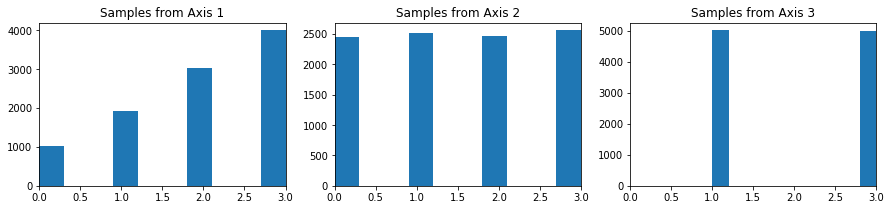

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,3))


plt.subplot(131)
plt.title("Samples from Axis 1")
plt.hist(sampled[0,:])
plt.xlim(0,3)

plt.subplot(132)
plt.title("Samples from Axis 2")
plt.hist(sampled[1,:])
plt.xlim(0,3)

plt.subplot(133)
plt.title("Samples from Axis 3")
plt.hist(sampled[2,:])
plt.xlim(0,3)

We see that the probability distributions match the sampling distributions: for Axis 1, we see that we are sampling with the probability distribution (1,2,3,4), for Axis 2, we see that we have a uniform distribution, then for Axis 3, all of the sampling is concentrated on 1,3 and equally distributed on both.